In [1]:
%pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 44.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is

In [2]:
import numpy as np
import pickle
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from collections import Counter

2025-09-30 20:42:20.156139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759264940.348450      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759264940.406899      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Configuration
MAX_WORDS = 10000  # Vocabulary size
MAX_LEN = 250      # Maximum sequence length
EMBEDDING_DIM = 100  # Word2Vec embedding dimension
BATCH_SIZE = 64
EPOCHS = 5

In [4]:
# Load dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MAX_WORDS)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training samples: 25000
Testing samples: 25000


In [5]:
# Get word index
word_index = imdb.get_word_index()
reverse_word_index = {v + 3: k for k, v in word_index.items()}
reverse_word_index[0] = '<PAD>'
reverse_word_index[1] = '<START>'
reverse_word_index[2] = '<UNK>'
reverse_word_index[3] = '<UNUSED>'

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Convert sequences back to text for Word2Vec training
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i, '<UNK>') for i in encoded_review])

# Convert all training reviews to sentences (list of words)
sentences = []
for review in X_train:
    words = [reverse_word_index.get(i, '<UNK>') for i in review]
    sentences.append(words)

In [7]:
# Train Word2Vec model
print("Training Word2Vec model")
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    sg=0  # 0 for CBOW, 1 for Skip-gram
)
print(f"Word2Vec vocabulary size: {len(w2v_model.wv)}")

Training Word2Vec model
Word2Vec vocabulary size: 9998


In [8]:
# Create embedding matrix
print("Creating embedding matrix...")
vocab_size = min(MAX_WORDS, len(word_index) + 4)  # +4 for special tokens
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

words_found = 0
for word, idx in word_index.items():
    if idx >= MAX_WORDS:
        continue
    idx = idx + 3  # Add offset for special tokens
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
        words_found += 1

print(f"Pre-trained embeddings loaded for {words_found}/{vocab_size} words")

Creating embedding matrix...
Pre-trained embeddings loaded for 9996/10000 words


In [9]:
# Pad sequences to fixed length
print("Padding sequences...")
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)

Padding sequences...


In [ ]:
# Build the model with Word2Vec embeddings
print("Building model with Word2Vec embeddings...")
model = Sequential([
    Embedding(
        vocab_size, 
        EMBEDDING_DIM, 
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=True  
    ),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


Building model with Word2Vec embeddings...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1759265115.425389      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [13]:
# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.build(input_shape=(None, MAX_LEN))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 250, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,170,881 (4.47 MB)

 Trainable params: 1,170,881 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 570s 1s/step - accuracy: 0.6785 - loss: 0.5888 - val_accuracy: 0.8231 - val_loss: 0.3985
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 558s 1s/step - accuracy: 0.7834 - loss: 0.4676 - val_accuracy: 0.8572 - val_loss: 0.3441
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - accuracy: 0.8602 - loss: 0.3444 - val_accuracy: 0.8468 - val_loss: 0.3746
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - accuracy: 0.8659 - loss: 0.3190 - val_accuracy: 0.8941 - val_loss: 0.2680
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 558s 1s/step - accuracy: 0.9012 - loss: 0.2540 - val_accuracy: 0.8956 - val_loss: 0.2579


In [ ]:
# Evaluate the model
print("\nEvaluating model")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# Predictions
y_pred_probs = model.predict(X_test, verbose=0)                 
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Evaluating model...
Test Accuracy: 0.8956
Test Loss: 0.2579
F1-Score: 0.8982

Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.87      0.89     12500
    Positive       0.88      0.92      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000




Confusion Matrix:
[[10876  1624]
 [  987 11513]]


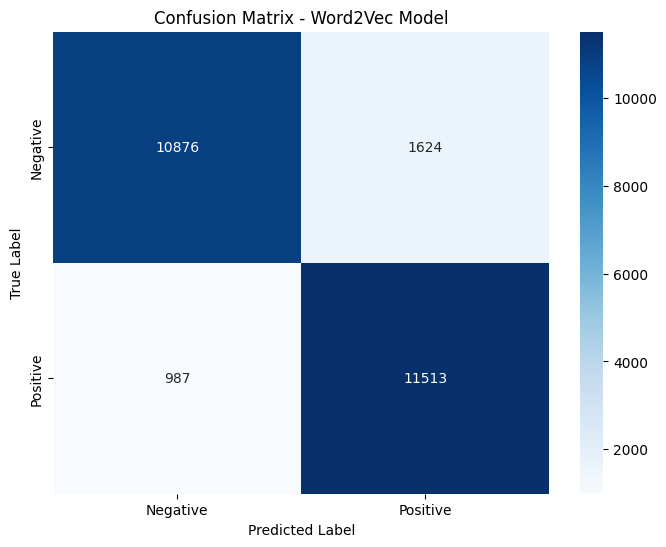

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Word2Vec Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')

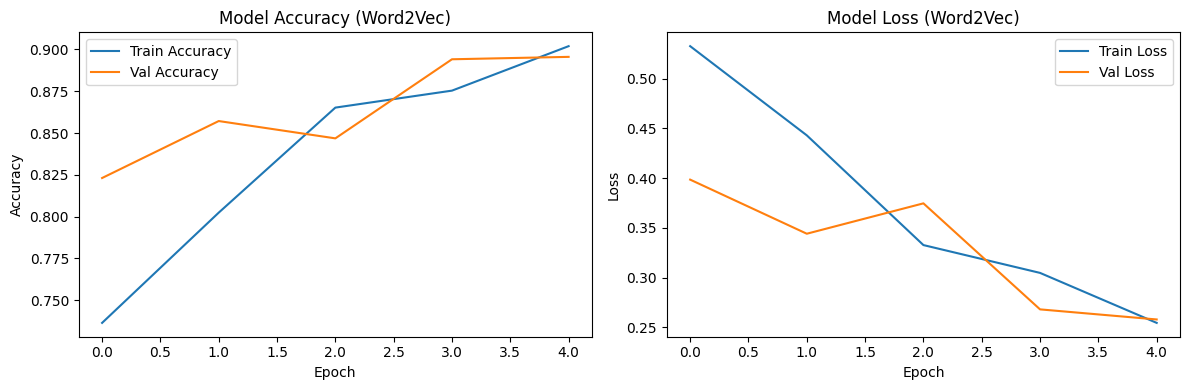

In [17]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (Word2Vec)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (Word2Vec)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

In [18]:
# Save the model
model.save('sentiment_model.h5')
print("Model saved as 'sentiment_model.h5'")

# Save Word2Vec model
w2v_model.save('word2vec.model')
print("Word2Vec model saved as 'word2vec.model'")

# Save word index for tokenization
tokenizer_config = {
    'word_index': word_index,
    'max_words': MAX_WORDS,
    'max_len': MAX_LEN,
    'reverse_word_index': reverse_word_index
}
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer_config, f)
print("Tokenizer saved as 'tokenizer.pkl'")

Model saved as 'sentiment_model.h5'
Word2Vec model saved as 'word2vec.model'
Tokenizer saved as 'tokenizer.pkl'
